# MARS5001 Coastal Processes and Systems


# NB1 - Shallow Water Equation 2D

## Overview
<p>The shallow water equations (SWE) are hyperbolic partial differential equations that describe fluid flow when the fluid is *"shallow"*.</p> 

<p>They're derived from the Navier-Stokes equations for cases where horizontal length is much greater than vertical length. The vertical velocity is assumed to be effectively zero and so the horizontal velocity is constant throughout the height of the fluid column.</p>

<p>In this notebook we will use ClawPack & PyClaw (documents for these <a href='http://www.clawpack.org/doc/pyclaw/'>modules</a>) to design a 2D model of the SWE.</p>

# SWE Theory

## Conservative form

The shallow water equations are derived from equations of conservation of mass and conservation of momentum (the Navier–Stokes equations), which hold even when the assumptions of shallow water break down, such as across a hydraulic jump. In the case of no Coriolis, frictional or viscous forces, the shallow-water equations are:
<br/>

$$ \frac{\partial \eta}{\partial t} + \frac{\partial (\eta u)}{\partial x} + \frac{\partial (\eta v)}{\partial y}  = 0 $$
$$ \frac{\partial \eta u}{\partial t} + \frac{\partial }{\partial x} \left( \eta u^2 + \frac{1}{2}g \eta^2 \right) +  \frac{\partial \eta uv}{\partial y}  = 0 $$
$$ \frac{\partial \eta v}{\partial t} +  \frac{\partial \eta uv}{\partial x} + \frac{\partial }{\partial y} \left( \eta v^2 + \frac{1}{2}g \eta^2 \right)  = 0 $$

+ $u,v$: averaged velocity in $x,y$ direction across the vertical column
+ $t$: time
+ $\eta$: water column height
+ $g$: acceleration due to gravity

The first equation is derived from mass conservation, the second two from momentum conservation.

<br/>

## Some notes on the derivation of the SWE

In [2]:
from IPython.core.display import HTML
HTML('<iframe src=http://www.ifu.ethz.ch/EFM/education/NHY_Kapitel_8_EN.pdf width=600 height=500></iframe>')

# Applications
Shallow water equations model the propagation of disturbances in water and other incompressible fluids. They are used extensively for (natural?) hazards such as tsunami or flood modeling as we've seen in last lecture. Their 2D forms are also use to simulate wave motion near coasts and harbours. 

### Simulation of Huricane and storm surge:
Based on SWAN+ADCIRC from C. Dietrich (2011)
<img src='http://www.caseydietrich.com/SWAN+ADCIRC/20120627/Gustav_HS-Wind_GOMEX.gif' >

# Getting started

We will use Clawpack/PyClaw modules to build our own SWE model. 

First we import the riemann and pyclaw libraries from the clawpack bundle. The riemann library contains the Fortran solvers and pyclaw allows us to utilize those Fortran solvers within a Python environment.

So we simply import the modules we will need!


<small>
**Acknowlegement** &mdash; This  is based on the teaching material compiled by Prof. L. Barba <a href:'https://github.com/barbagroup/PASI2013/blob/master/README.md'>PASI program</a>: I will highly recommend to have a look at this website.
</small>

In [2]:
%matplotlib inline
from clawpack import riemann
from clawpack import pyclaw
import numpy 
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display

# Radial Dam

Using **PyClaw** will be simulating the bursting of a radial dam.

Imagine a column of water of some height, h, which is greater than the surrounding water level. The dam holding the column in place is instantaneously removed and the water rushes out as a radial wave.

For these equations, the Clawpack solver we want is called <code>shallow_roe_with_efix_2D</code>.

In [4]:
solver = pyclaw.ClawSolver2D(riemann.shallow_roe_with_efix_2D)
solver.limiters = pyclaw.limiters.tvd.MC

## Domain definition 

Ok, now it's time to set up our domain. We have to choose a range to run the problem over, and the number of grid points that we'd like to insert.
The domain is set as a 10 x 10 m square with 150 nodes in both x and y dimensions

In [5]:
xlower = -5.
xupper = 5.
ylower = -5.
yupper = 5.
    
###Number of Grid Points###
nx = 150
ny = 150

In [6]:
x = pyclaw.Dimension('x', xlower, xupper, nx)
y = pyclaw.Dimension('y', ylower, yupper, ny)

In [7]:
domain = pyclaw.Domain([x,y])
state = pyclaw.State(domain, solver.num_eqn)

grav = 1.0
state.problem_data['grav'] = grav

## Dam initial conditions

Ok, now let's set up our initial conditions. We'll be looking at a classic shallow water example, the 'dam break.' We're going to set up a 'step' of water and then see what happens when we let it go. First, let's grab the positions of our nodes from our state object.

In [8]:
###Initial Conditions###
damRadius = 0.5

###Inside dam###
height_inside = 2.
x_velocity_inside = 0.
y_velocity_inside = 0.

###Outside dam###
height_outside = 1.0
x_velocity_outside = 0.
y_velocity_outside = 0.

We place the center of the radial dam at coordinate (−4,−4)

In [9]:
x0 = -4.
y0 = -4.

Setting initial conditions is a little trickier in 2D, but we can manage. We'll need the x- and y-coordinates of the nodes first, which can be copied from the <code>state.grid</code> object.

In [10]:
xCenter = state.grid.x.centers.copy()
yCenter = state.grid.y.centers.copy()

### Grid generation

Now we'll use the <code>numpy.meshgrid</code> function to generate the coordinates for a meshed grid.

In [11]:
Y,X = numpy.meshgrid(yCenter,xCenter)

We've specified a dam radius for our water column, so we need to know the radial distance of every point from the center of our dam in order to choose where to set the water height above the standard.

In [12]:
rad = numpy.sqrt((X-x0)**2 + (Y-y0)**2)

Like for the 1D model from last week, we need to set the initial conditions in the state object. This works the same way as it does with the 1D example, except that now, the q array is a three-dimensional array. The first row stores water height in both x and y coordinates. The second row stores water velocity in the x direction and the third row stores water velocity in the y direction.

In [13]:
state.q[0,:,:] = height_inside*(rad<=damRadius) +\
                    height_outside*(rad>damRadius)
    
state.q[1,:,:] = 0.
state.q[2,:,:] = 0.

### Boundaries

<p>We need to set boundary conditions at 4 boundaries now. We'll use the wall boundary condition so that waves will be reflected back in to our domain. We can specify the condition at each wall as follows:</p>
<small>
<p> <code>solver.bc_lower[0] = pyclaw.BC.wall</code></p>
<p> <code>solver.bc_lower[1] = pyclaw.BC.wall</code></p>
<p> <code>solver.bc_upper[0] = pyclaw.BC.wall</code></p>
<p> <code>solver.bc_upper[1] = pyclaw.BC.wall</code></p>
</small>

<p>but it's kind of a pain, especially if we want the same conditions at all boundaries. If that's the case, there's a shortcut.</p>

In [14]:
solver.all_bcs = pyclaw.BC.wall

# Computing the solution

With all of our initial and boundary conditions set, we again set up a controller to manage the problem for us and then it's time to run our problem.

In [15]:
claw = pyclaw.Controller()
claw.tfinal = 10
claw.solution = pyclaw.Solution(state,domain)
claw.solver = solver
claw.output_format = None 
claw.output_style=1
claw.keep_copy = True
claw.num_output_times = 50

In [16]:
claw.run()
 

2015-03-15 22:33:37,973 INFO CLAW: Solution 0 computed for time t=0.000000
2015-03-15 22:33:38,025 INFO CLAW: Solution 1 computed for time t=0.200000
2015-03-15 22:33:38,069 INFO CLAW: Solution 2 computed for time t=0.400000
2015-03-15 22:33:38,107 INFO CLAW: Solution 3 computed for time t=0.600000
2015-03-15 22:33:38,152 INFO CLAW: Solution 4 computed for time t=0.800000
2015-03-15 22:33:38,198 INFO CLAW: Solution 5 computed for time t=1.000000
2015-03-15 22:33:38,244 INFO CLAW: Solution 6 computed for time t=1.200000
2015-03-15 22:33:38,291 INFO CLAW: Solution 7 computed for time t=1.400000
2015-03-15 22:33:38,338 INFO CLAW: Solution 8 computed for time t=1.600000
2015-03-15 22:33:38,385 INFO CLAW: Solution 9 computed for time t=1.800000
2015-03-15 22:33:38,425 INFO CLAW: Solution 10 computed for time t=2.000000
2015-03-15 22:33:38,465 INFO CLAW: Solution 11 computed for time t=2.200000
2015-03-15 22:33:38,505 INFO CLAW: Solution 12 computed for time t=2.400000
2015-03-15 22:33:38,54

{'cflmax': 0.9874764396305391,
 'dtmax': 0.052871086097764912,
 'dtmin': 0.03664736548874072,
 'numsteps': 239}

# Visualizing results

We need to tell matplotlib that we want a 3d projection plot. Our results from **PyClaw** are stored in claw.frames[x].q[0,:,:] and since this is a 3d projection, we'll re-use our meshgrid coordinates X and Y.


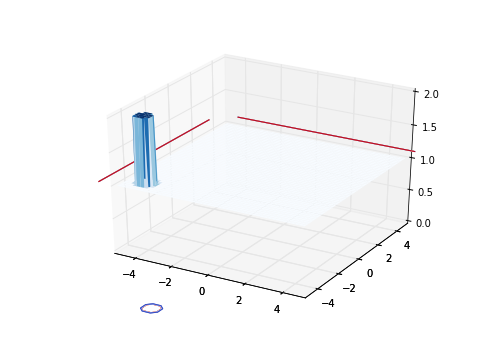
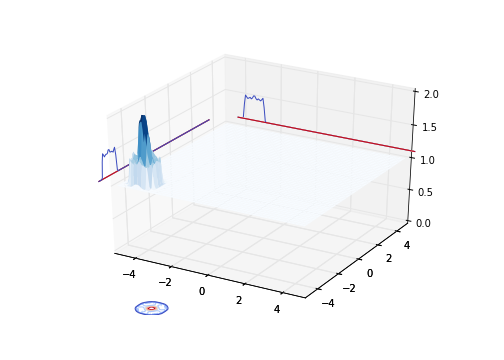
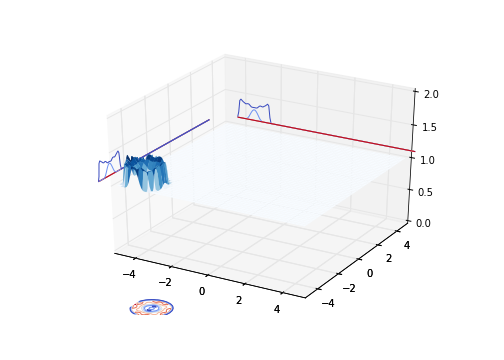
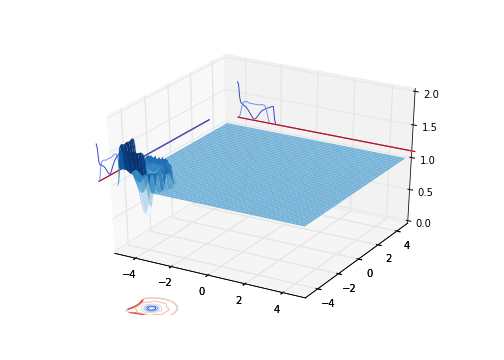
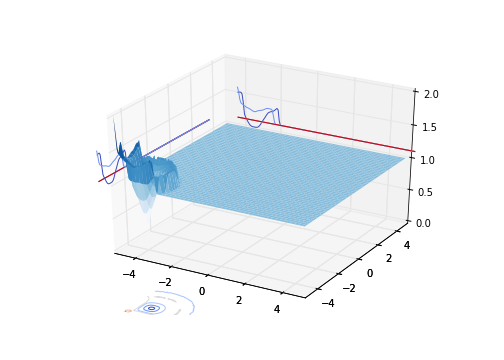
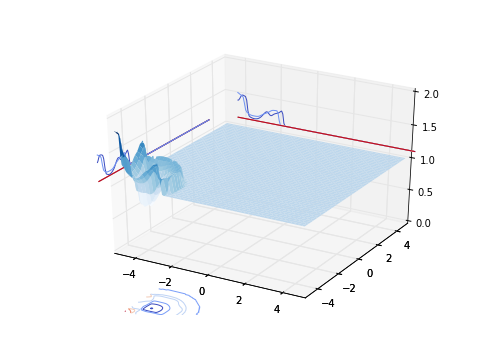
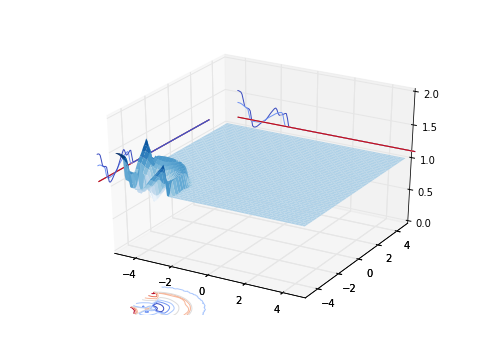
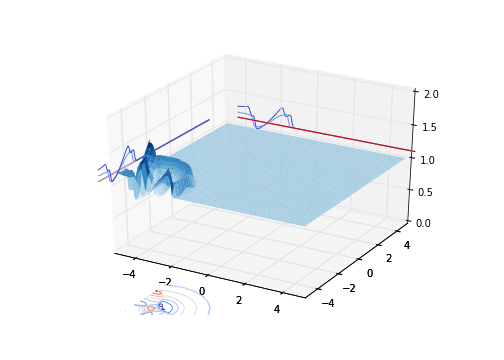
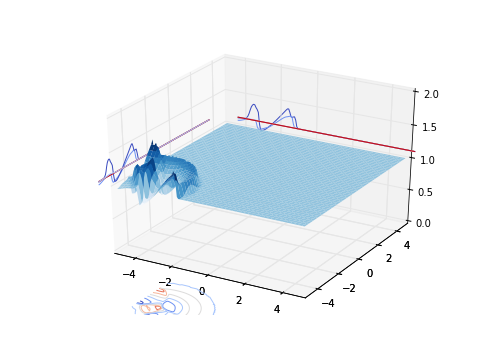
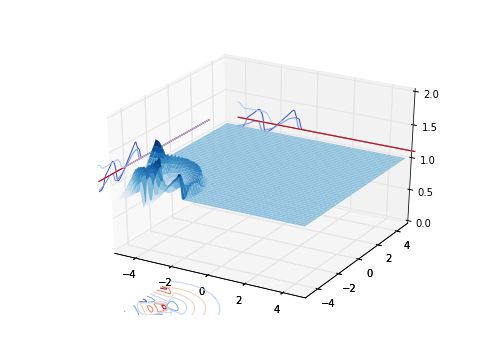
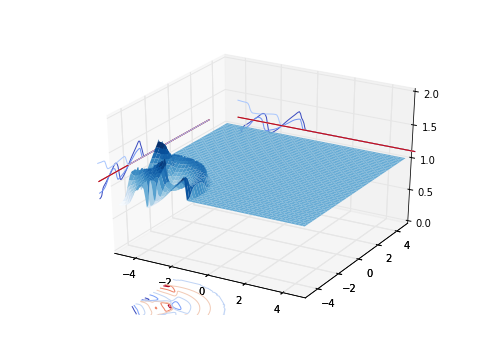
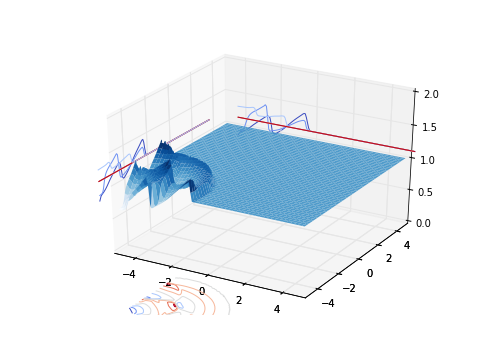
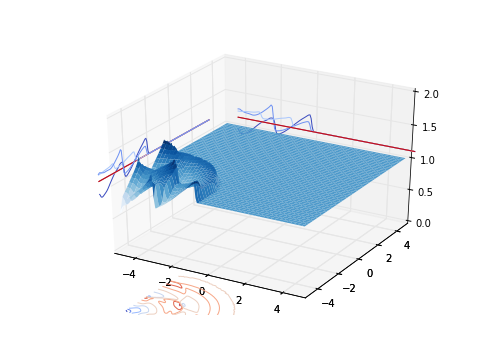
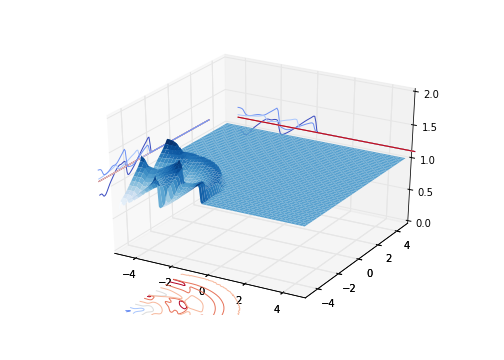
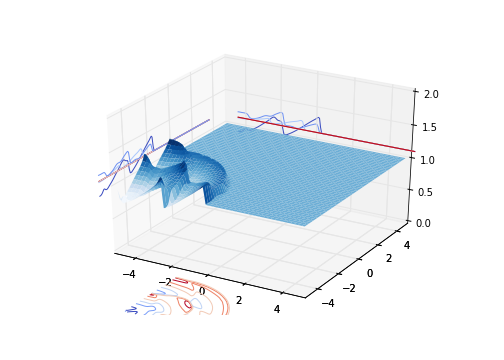
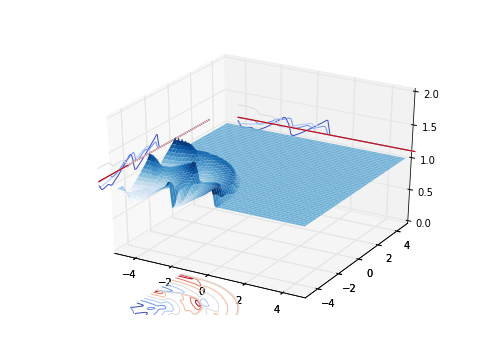
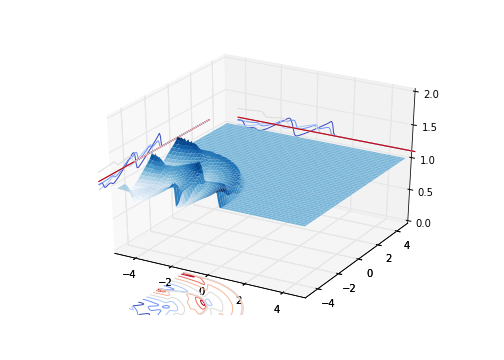
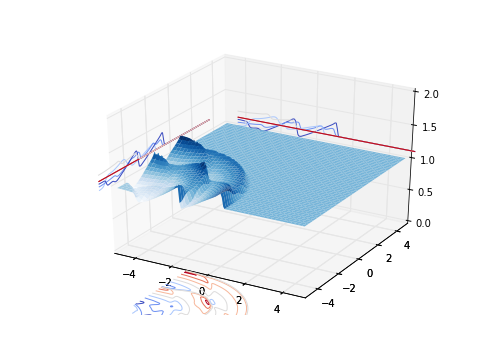
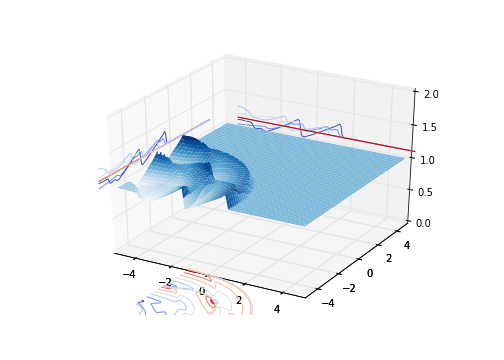
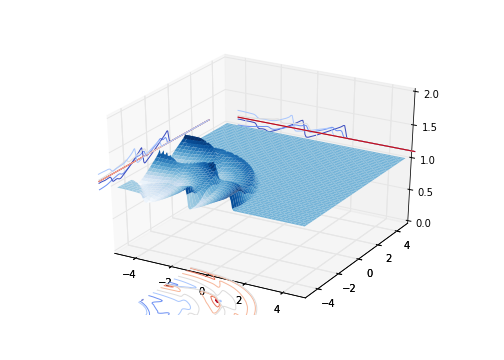
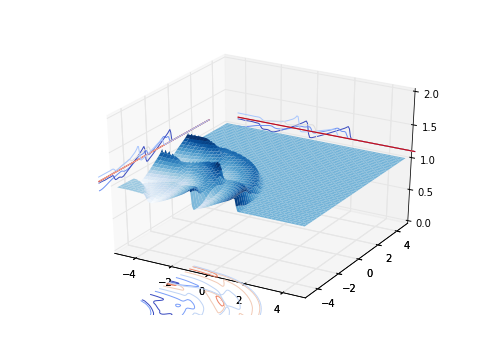
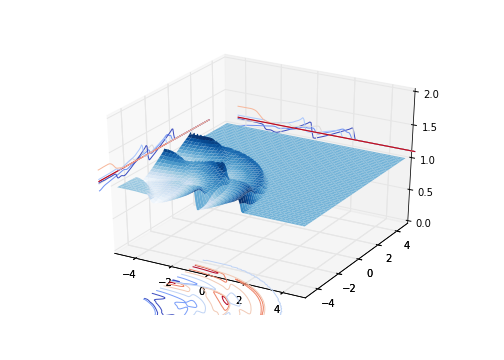
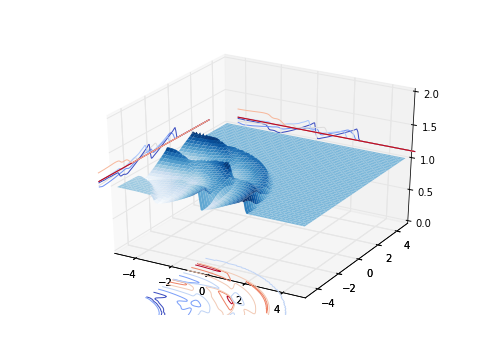
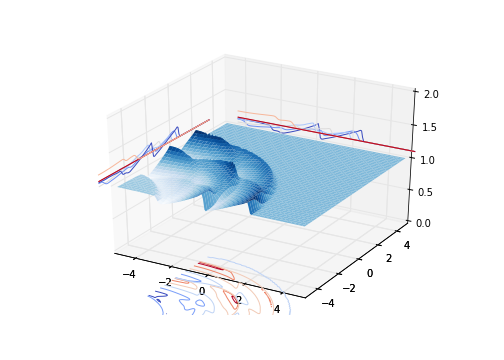
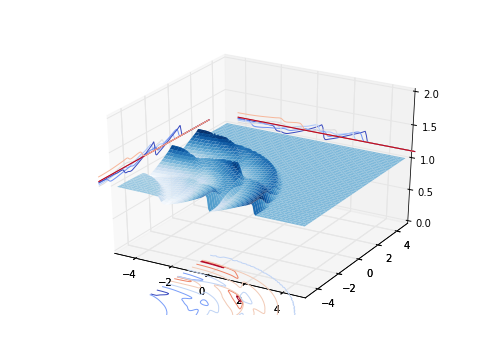
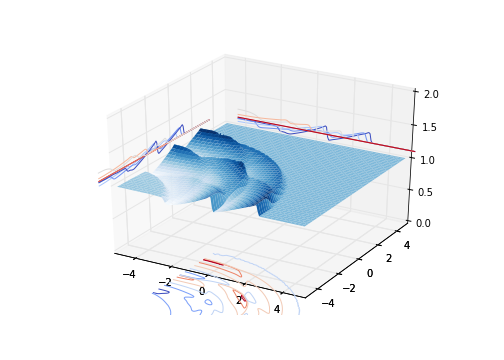
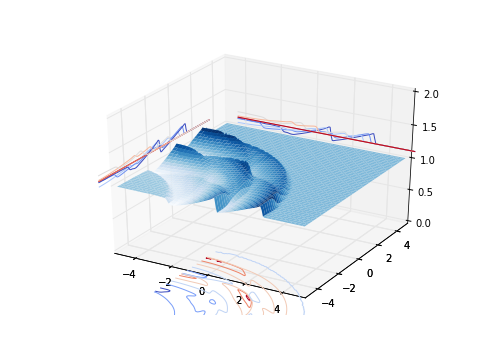
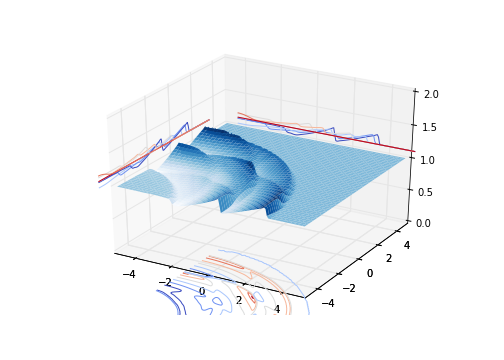
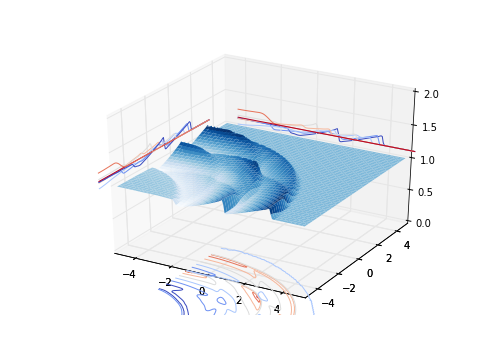
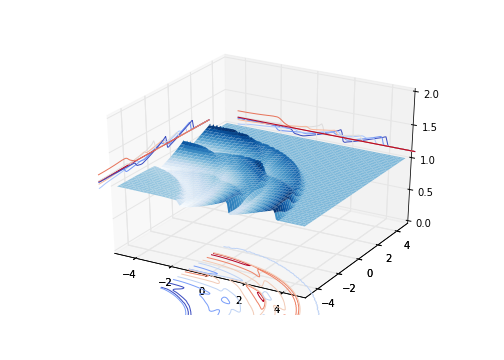
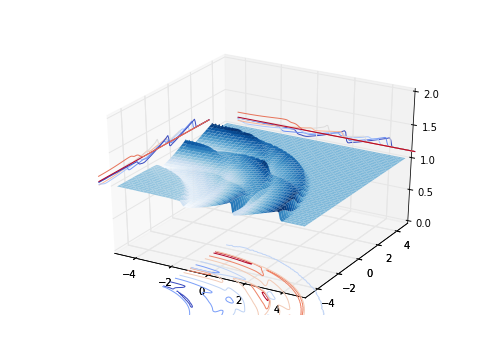
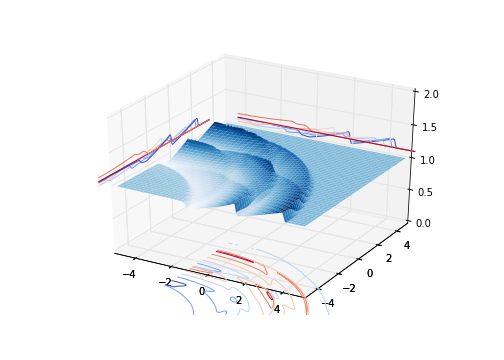
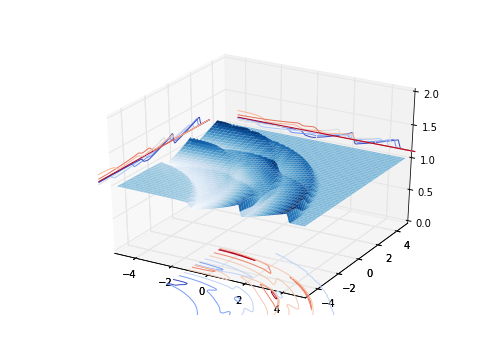
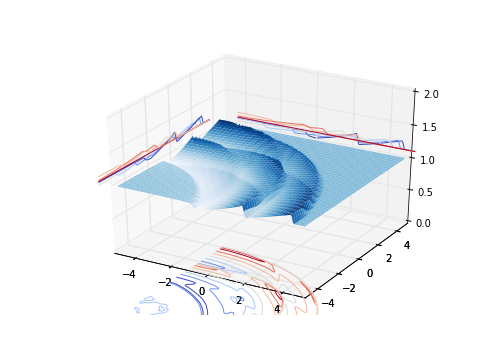
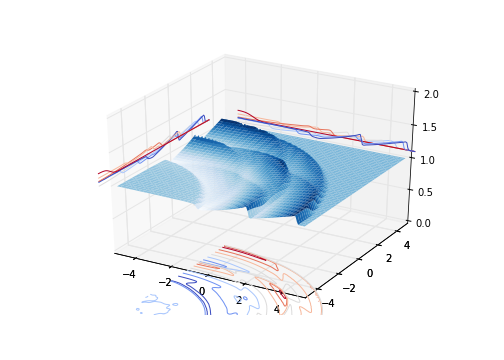
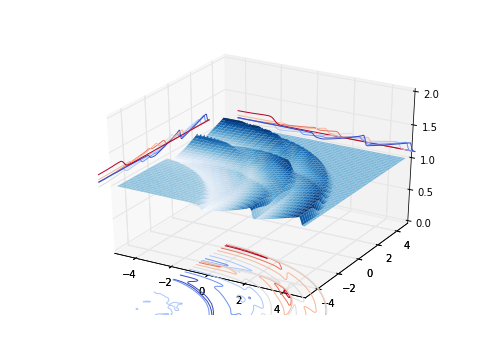
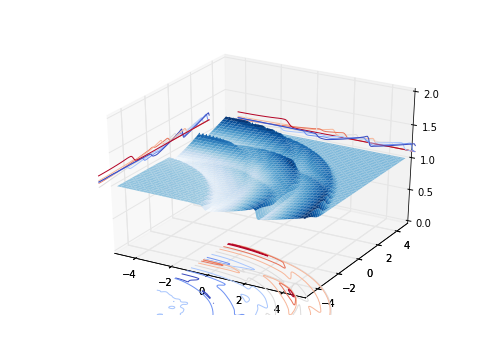
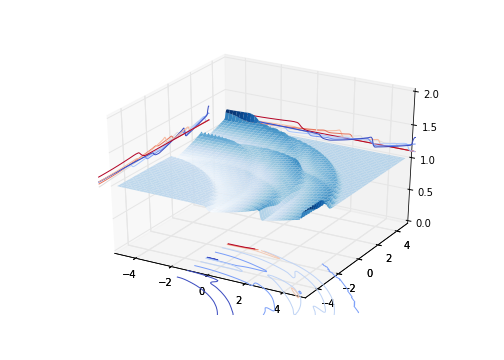
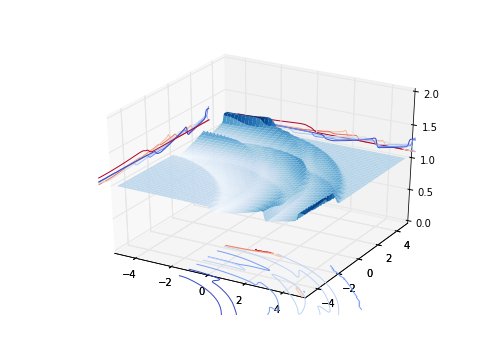
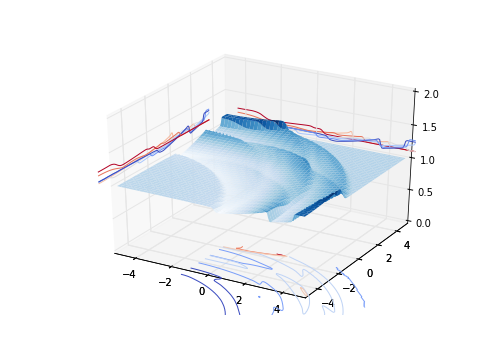
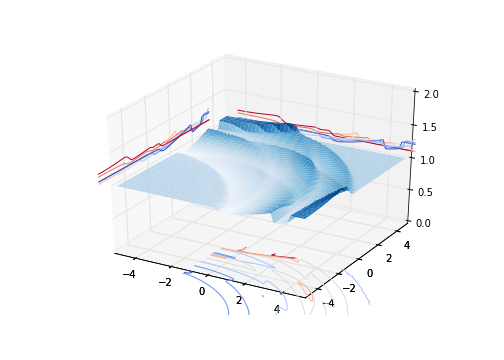
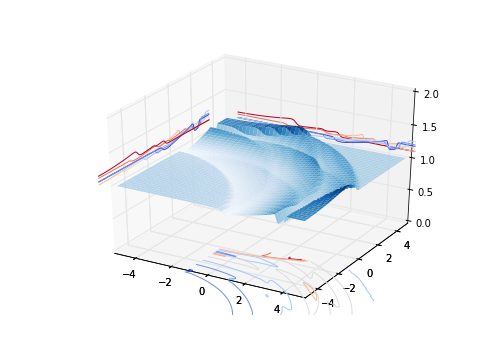
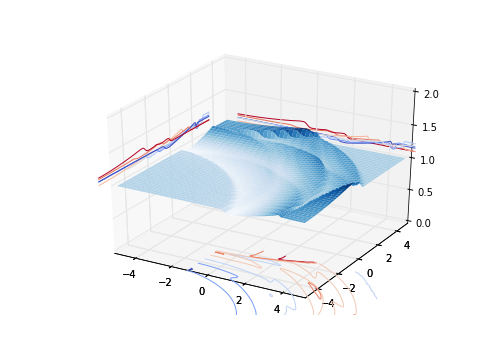
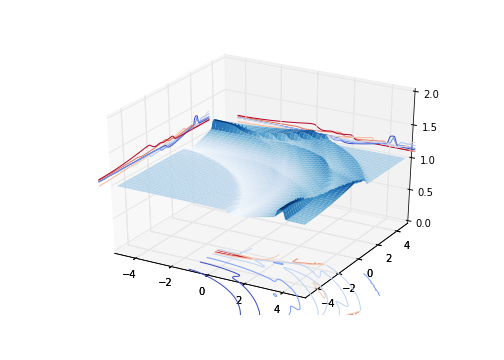
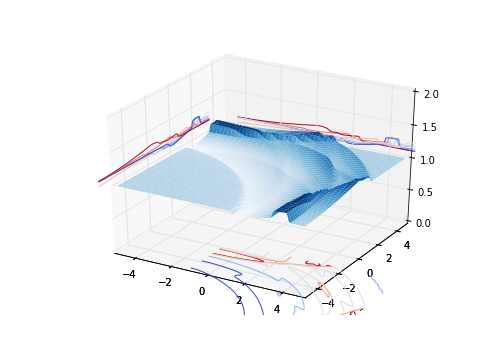
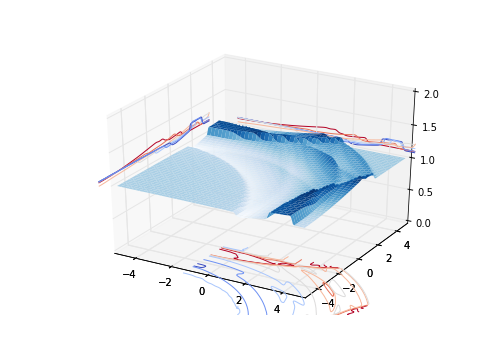
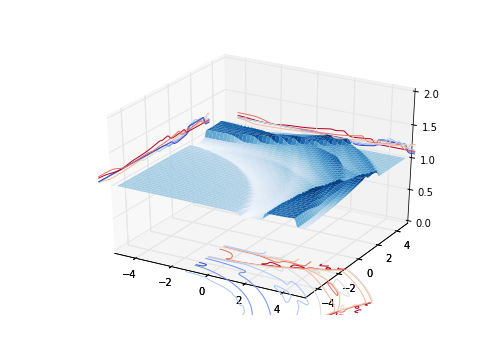
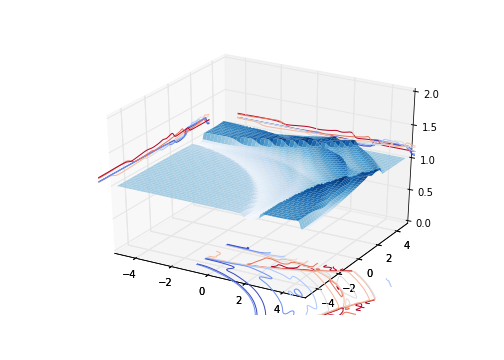
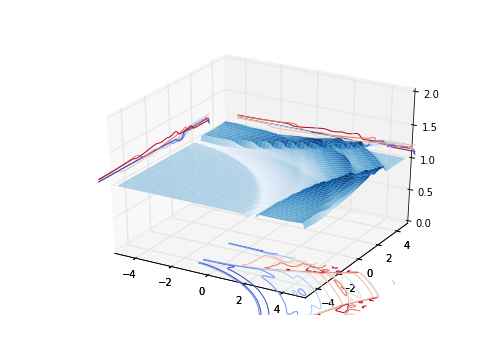

In [17]:
fig = plt.figure(figsize=(7,5))
ax = fig.gca(projection='3d')

ax.plot_surface(X,Y,claw.frames[0].q[0,:,:], rstride=3, cstride=3,\
                       cmap=cm.Blues, antialiased=True, linewidth=0)
ax.contour(X,Y,claw.frames[0].q[0,:,:], zdir='z', offset=-1, cmap=cm.coolwarm)
ax.contour(X,Y,claw.frames[0].q[0,:,:], zdir='x', offset=-6, cmap=cm.coolwarm)
ax.contour(X,Y,claw.frames[0].q[0,:,:], zdir='y', offset=6, cmap=cm.coolwarm)
ax.set_zlim(0,2.)

def animate(i):
    ax.clear()
    ax.set_zlim(0,2.)
    ax.plot_surface(X,Y,claw.frames[i].q[0,:,:], rstride=3, cstride=3,\
                       cmap=cm.Blues, antialiased=True, linewidth=0)
    ax.contour(X,Y,claw.frames[i].q[0,:,:], zdir='z', offset=-1, cmap=cm.coolwarm)
    ax.contour(X,Y,claw.frames[i].q[0,:,:], zdir='x', offset=-6, cmap=cm.coolwarm)
    ax.contour(X,Y,claw.frames[i].q[0,:,:], zdir='y', offset=6, cmap=cm.coolwarm)
    return ax

animation.FuncAnimation(fig, animate,
                        frames=50,  # number of frames to draw
                        interval=40, # time (ms) on each frame
                        blit=True)